# Prophet

* https://facebook.github.io/prophet/docs/quick_start.html#python-api

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [10]:
#!pip install pytorch-common

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import random
import torch

from data   import standarizer, \
                   features_target_split, \
                   train_test_split

from data   import train_test_split

import pytorch_common.util    as pu
from prophet import Prophet

## Setup

In [11]:
CFG = {
    'etherium'         : { 'path': '../datasets/ETH_1H.csv',                 'variable': 'close' },
    'min-temp'         : { 'path': '../datasets/daily-min-temperatures.csv', 'variable': 'temp'  },
    'dataset'          : 'min-temp',
    'interval_width'   : 0.99, 
    'daily_seasonality': True,
    'times'            : 200
}

## Functions

In [12]:
def normalize(train_set, test_set):
    norm_train_set, norm_test_set = standarizer(train_set, test_set, columns=['y'])
    
    norm_train_set = norm_train_set[['ds', 'norm_y']]
    norm_train_set = norm_train_set.rename(columns={'norm_y': 'y' }).sort_values(by='ds',ascending=True)
    
    norm_test_set = norm_test_set[['ds', 'norm_y']]
    norm_test_set = norm_test_set.rename(columns={'norm_y': 'y' }).sort_values(by='ds',ascending=True)

    return norm_train_set, norm_test_set


def select_and_format_columns(dataset, column):
    dataset.columns = dataset.columns.str.lower()
    dataset       = dataset[['date', column]]
    dataset       = dataset.rename(columns={'date': 'ds', column: 'y' })
    dataset['ds'] = pd.to_datetime(dataset['ds'])
    dataset       = dataset.sort_values(by='ds',ascending=True)
    return dataset


def preprocessing(dataset, column, test_percent):
    dataset                       = select_and_format_columns(dataset, column)
    train_set, test_set           = train_test_split(dataset, test_percent = test_percent)
    norm_train_set, norm_test_set = normalize(train_set, test_set)

    print(norm_train_set.shape, norm_test_set.shape)

    return norm_train_set, norm_test_set

In [13]:
def predict(model, y_true_df, times):
    sns.set(rc = {'figure.figsize':(15,8)})

    y_true_df = y_true_df.head(times)

    y_pred_df = model.predict(y_true_df[['ds']])

    predictions_df = y_true_df.merge(y_pred_df, on='ds')
    predictions_df = predictions_df[['ds', 'y', 'yhat']]
    predictions_df = predictions_df.sort_values(by='ds',ascending=True)
    
    plot(
        predictions_df.yhat.values,
        predictions_df.y.values
    )
    model.plot(y_pred_df)

In [14]:
def plot(y_pred, y_true):
    sns.set_style("darkgrid")
    plt.plot(y_true, color='green',label="True")        
    plt.plot(y_pred, color='blue', label="Prediction")
    plt.legend()
    plt.show()

## Preprocessing

In [15]:
train_set, test_set = preprocessing(
    dataset      = pd.read_csv(CFG[CFG['dataset']]['path']),
    column       = CFG[CFG['dataset']]['variable'],
    test_percent = 0.1
)

(3285, 2) (365, 2)


# Model Definition

16:29:35 - cmdstanpy - INFO - Chain [1] start processing
16:29:35 - cmdstanpy - INFO - Chain [1] done processing


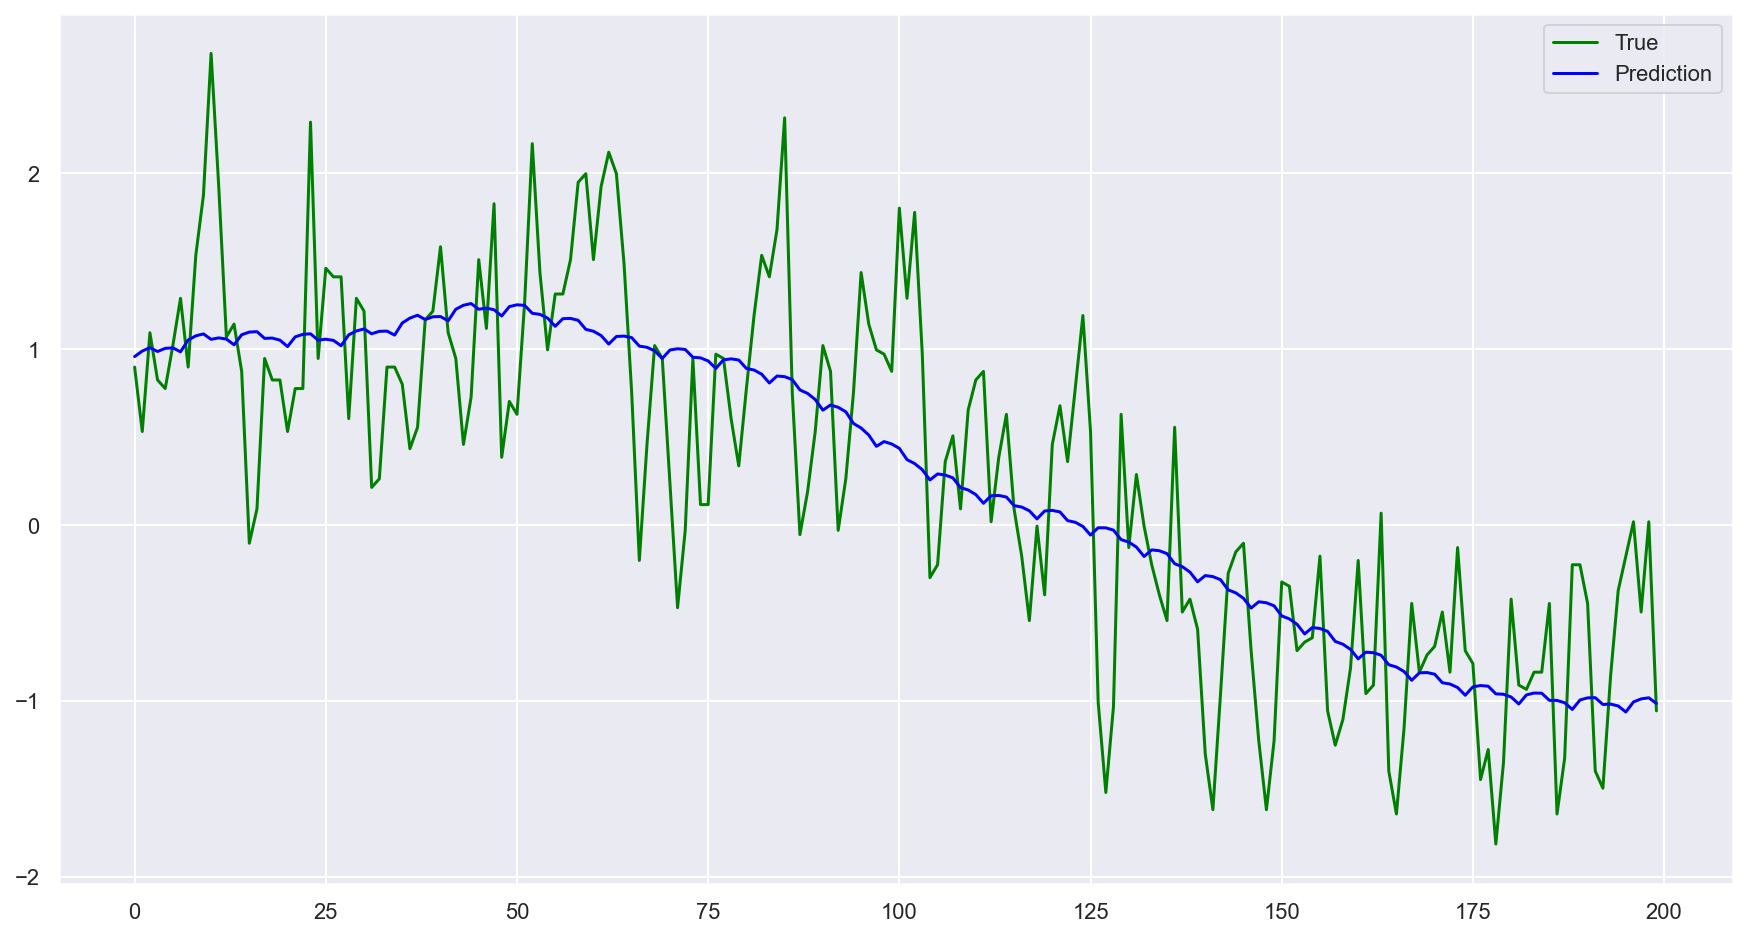

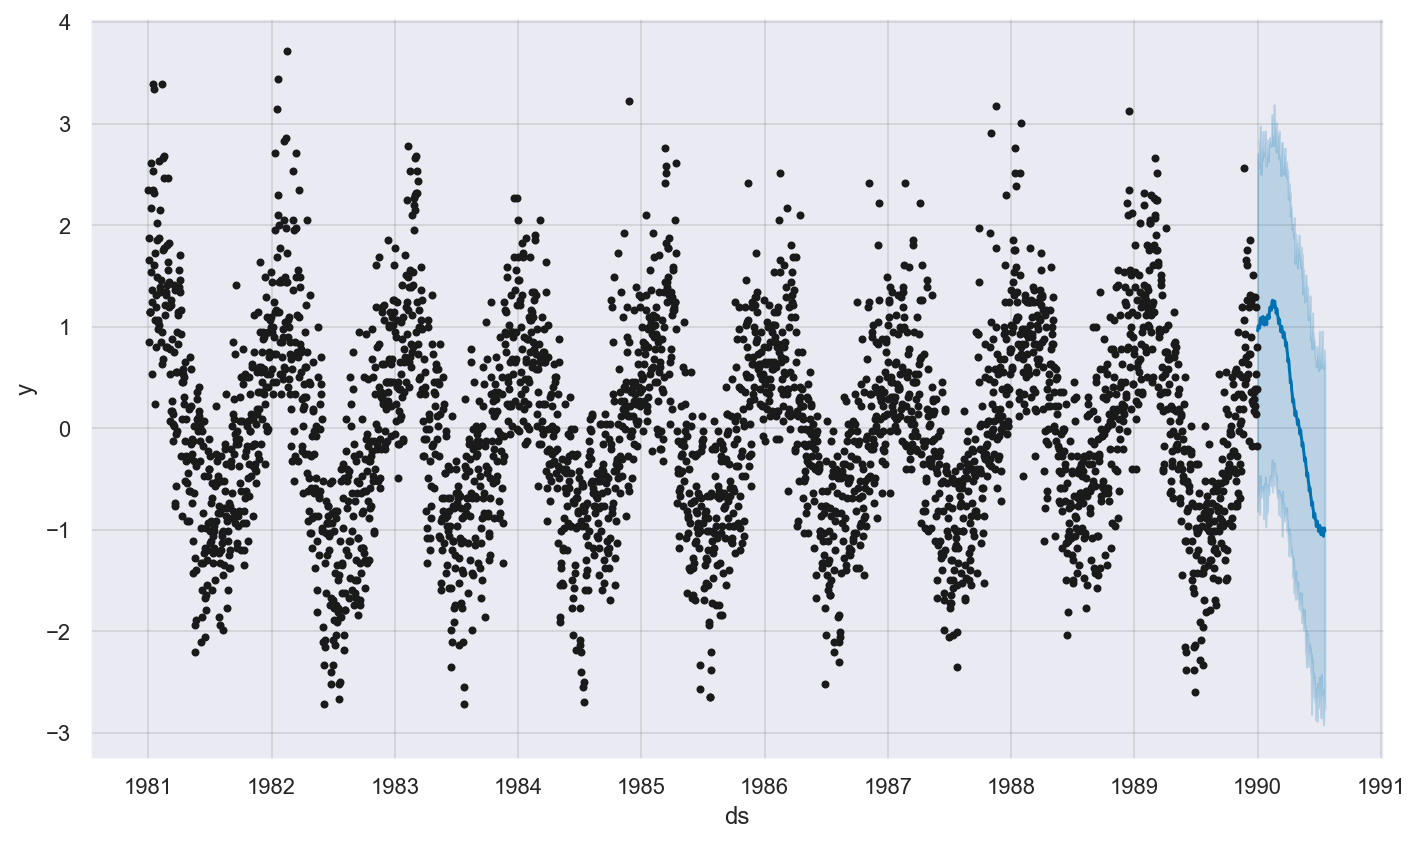

In [128]:
model = Prophet(
    interval_width    = CFG['interval_width'],
    daily_seasonality = CFG['daily_seasonality']
)

#model = Prophet()
#model.add_seasonality(name='anual',period=365,fourier_order=4)
model.fit(train_set)

fig=predict(model, test_set, times=CFG['times'])

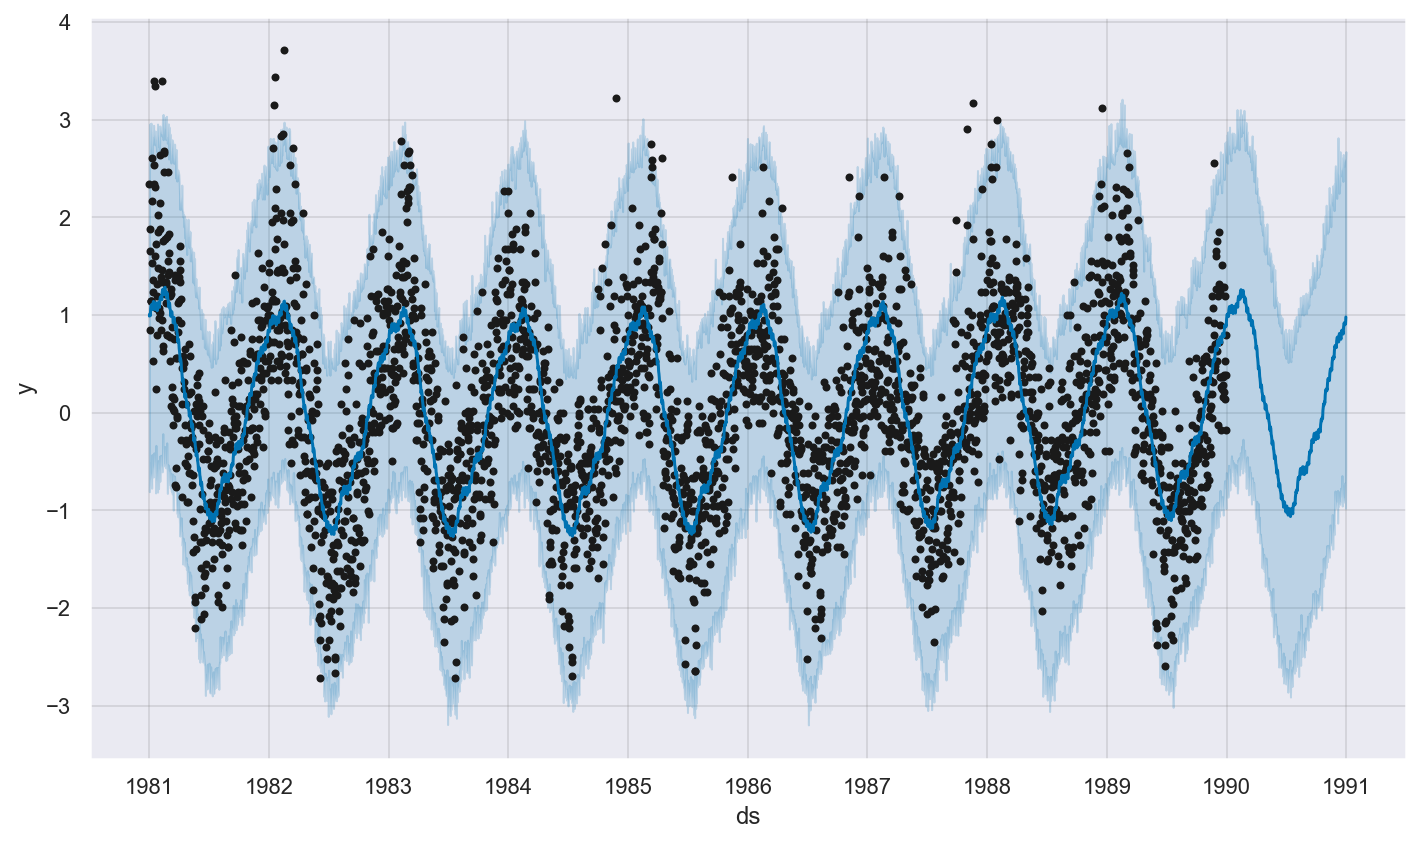

In [129]:
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
fig=model.plot(forecast)

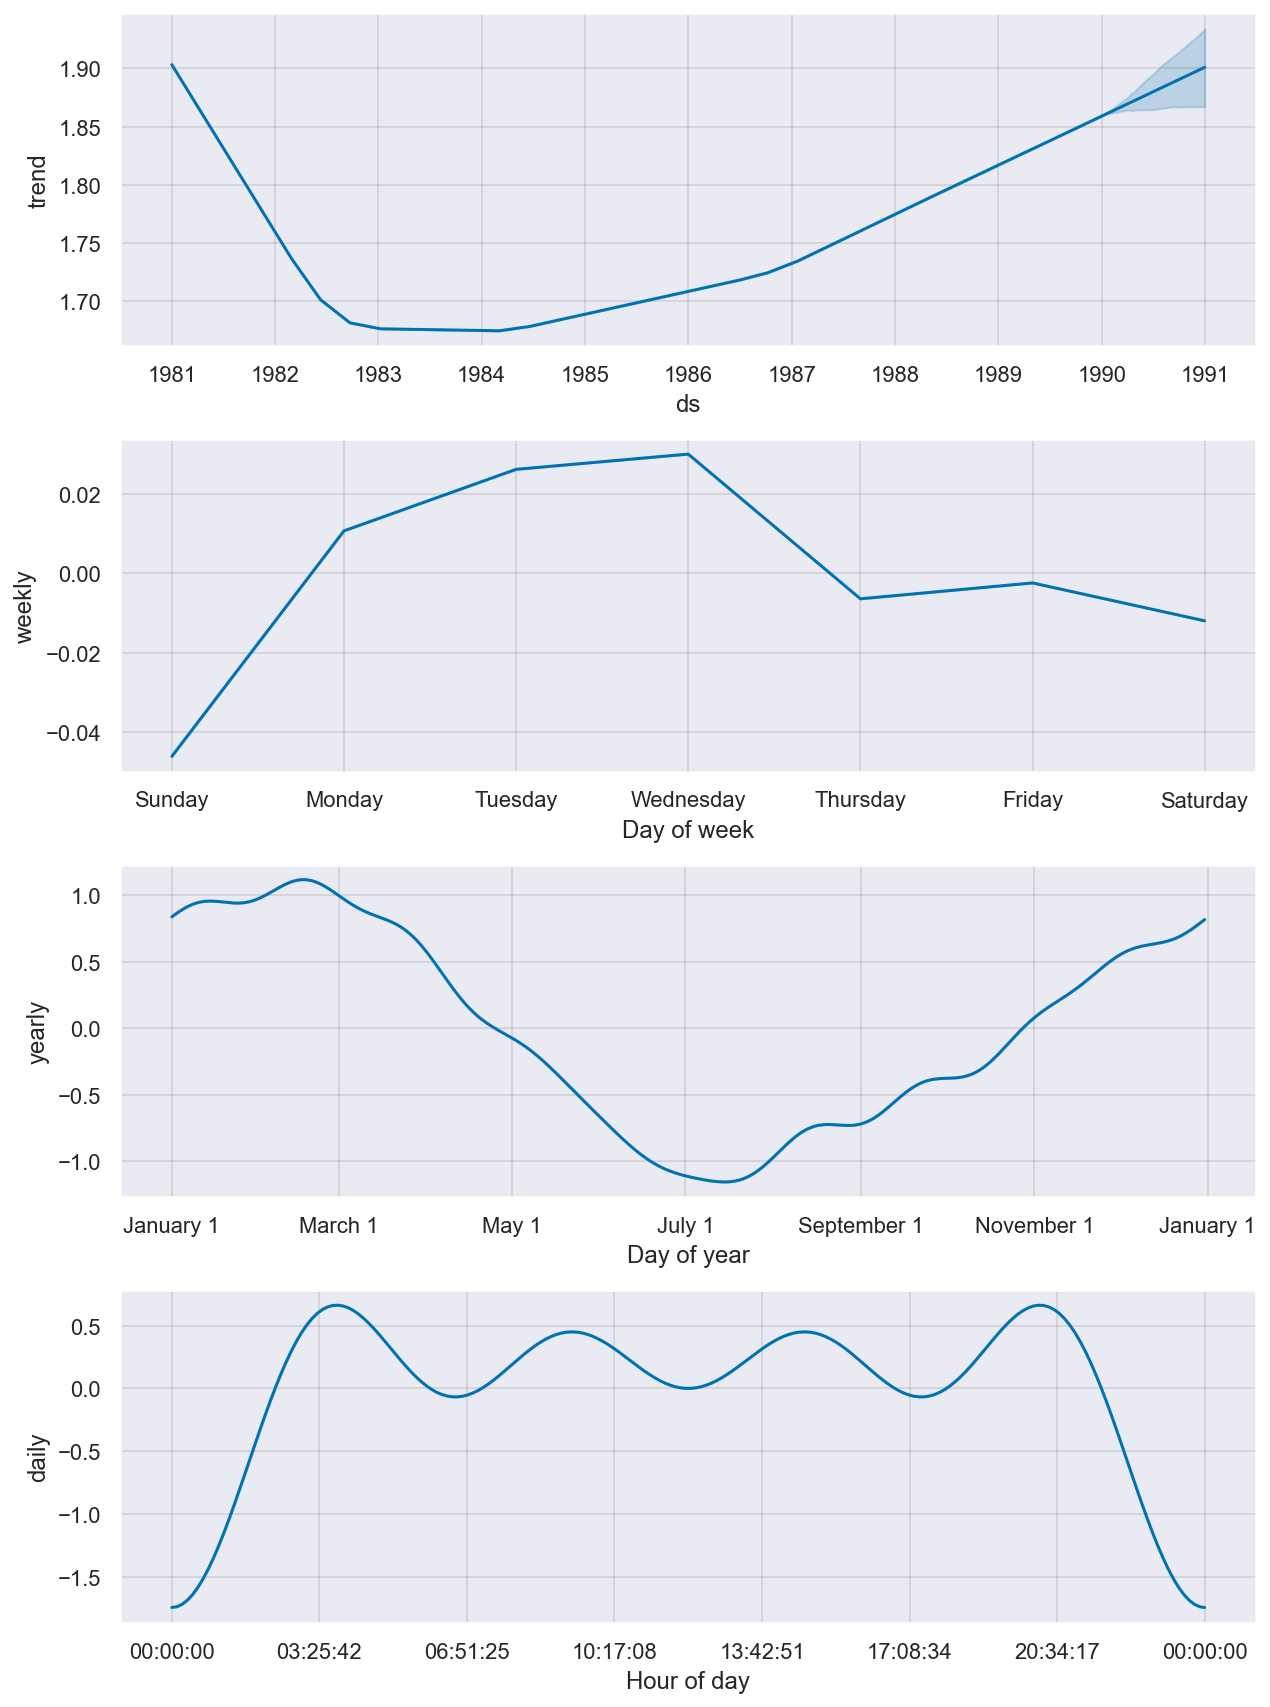

In [130]:
fig=model.plot_components(forecast)

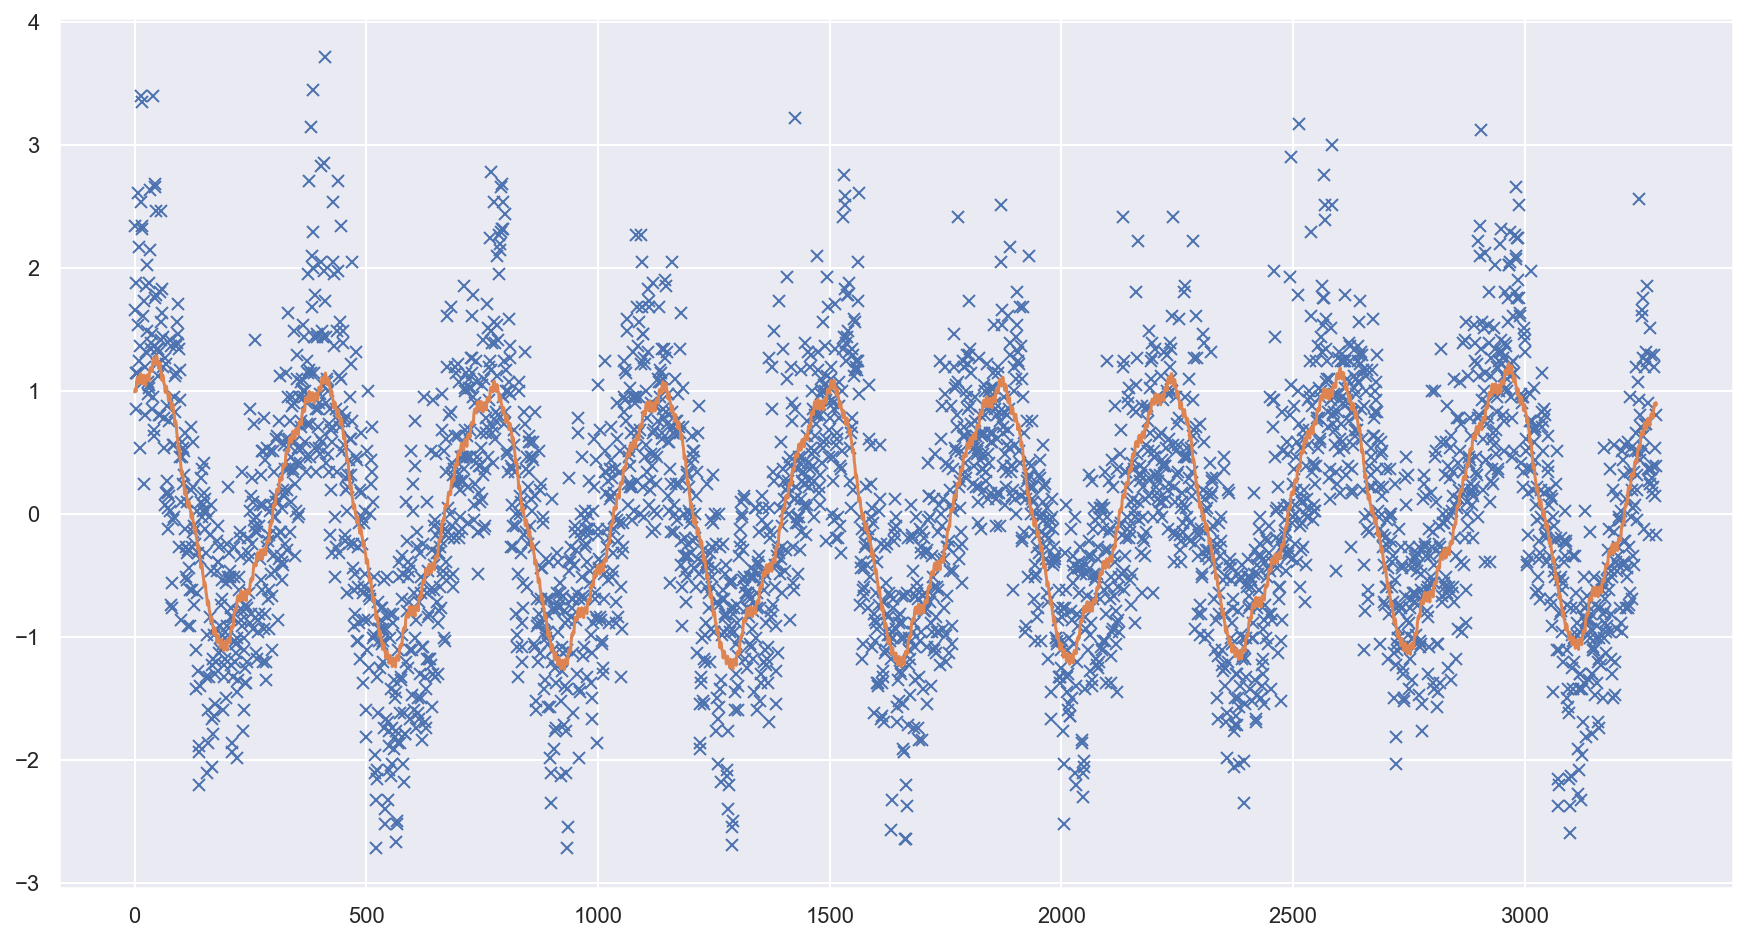

In [131]:
N=len(forecast)
y_fore=forecast['yhat']
y_fore_future=pd.DataFrame(y_fore[-365:])
y_fore_train=pd.DataFrame(y_fore[0:N-365])
plt.plot(train_set.y,'x')
plt.plot(y_fore_train)

In [132]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          3650 non-null   datetime64[ns]
 1   trend                       3650 non-null   float64       
 2   yhat_lower                  3650 non-null   float64       
 3   yhat_upper                  3650 non-null   float64       
 4   trend_lower                 3650 non-null   float64       
 5   trend_upper                 3650 non-null   float64       
 6   additive_terms              3650 non-null   float64       
 7   additive_terms_lower        3650 non-null   float64       
 8   additive_terms_upper        3650 non-null   float64       
 9   daily                       3650 non-null   float64       
 10  daily_lower                 3650 non-null   float64       
 11  daily_upper                 3650 non-null   float64     

## Análisis de estacionalidad

referencias de las siguientes funciones: https://www.kaggle.com/learn/time-series

In [85]:
#funciones para ploteo estacional, básico y períodograma
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

Amplio dataset a partir de la fecha

In [76]:
X = train_set.copy()

X['date'] = pd.to_datetime(X['ds'])
X['year'] = X['date'].dt.year
X['month'] = X['date'].dt.month
X['week'] = X['date'].dt.isocalendar().week
X['day_month'] = X['date'].dt.day
X['day_year'] = X['date'].dt.dayofyear 
X['day'] = X['date'].dt.dayofweek 
#X['weekend']=(X['day_week']>5).astype(int)
#X['friday']=(X['day_week']==4).astype(int)
#X["week"] = X.index.week

Si quiero agregar estaciones

In [82]:
bins = [0, 91, 183, 275, 366]
labels=['Winter', 'Spring', 'Summer', 'Fall'] #hemisferio norte
labels=['Summer', 'Fall','Winter', 'Spring'] #hemisferio sur
doy = X.day_year
X['season'] = pd.cut(doy + 11 - 366*(doy > 355), bins=bins, labels=labels)
X.season

0       Summer
1       Summer
2       Summer
3       Summer
4       Summer
         ...  
3280    Summer
3281    Summer
3282    Summer
3283    Summer
3284    Summer
Name: season, Length: 3285, dtype: category
Categories (4, object): ['Summer' < 'Fall' < 'Winter' < 'Spring']

En el sigte. gráfico se aprecia que el patrón de temperatura para las 52 semanas del año se repite (aprox.) cada año.  
El dataset de temperatura mínima diaria es de Melbourne, estaciones coomo en Argentina.

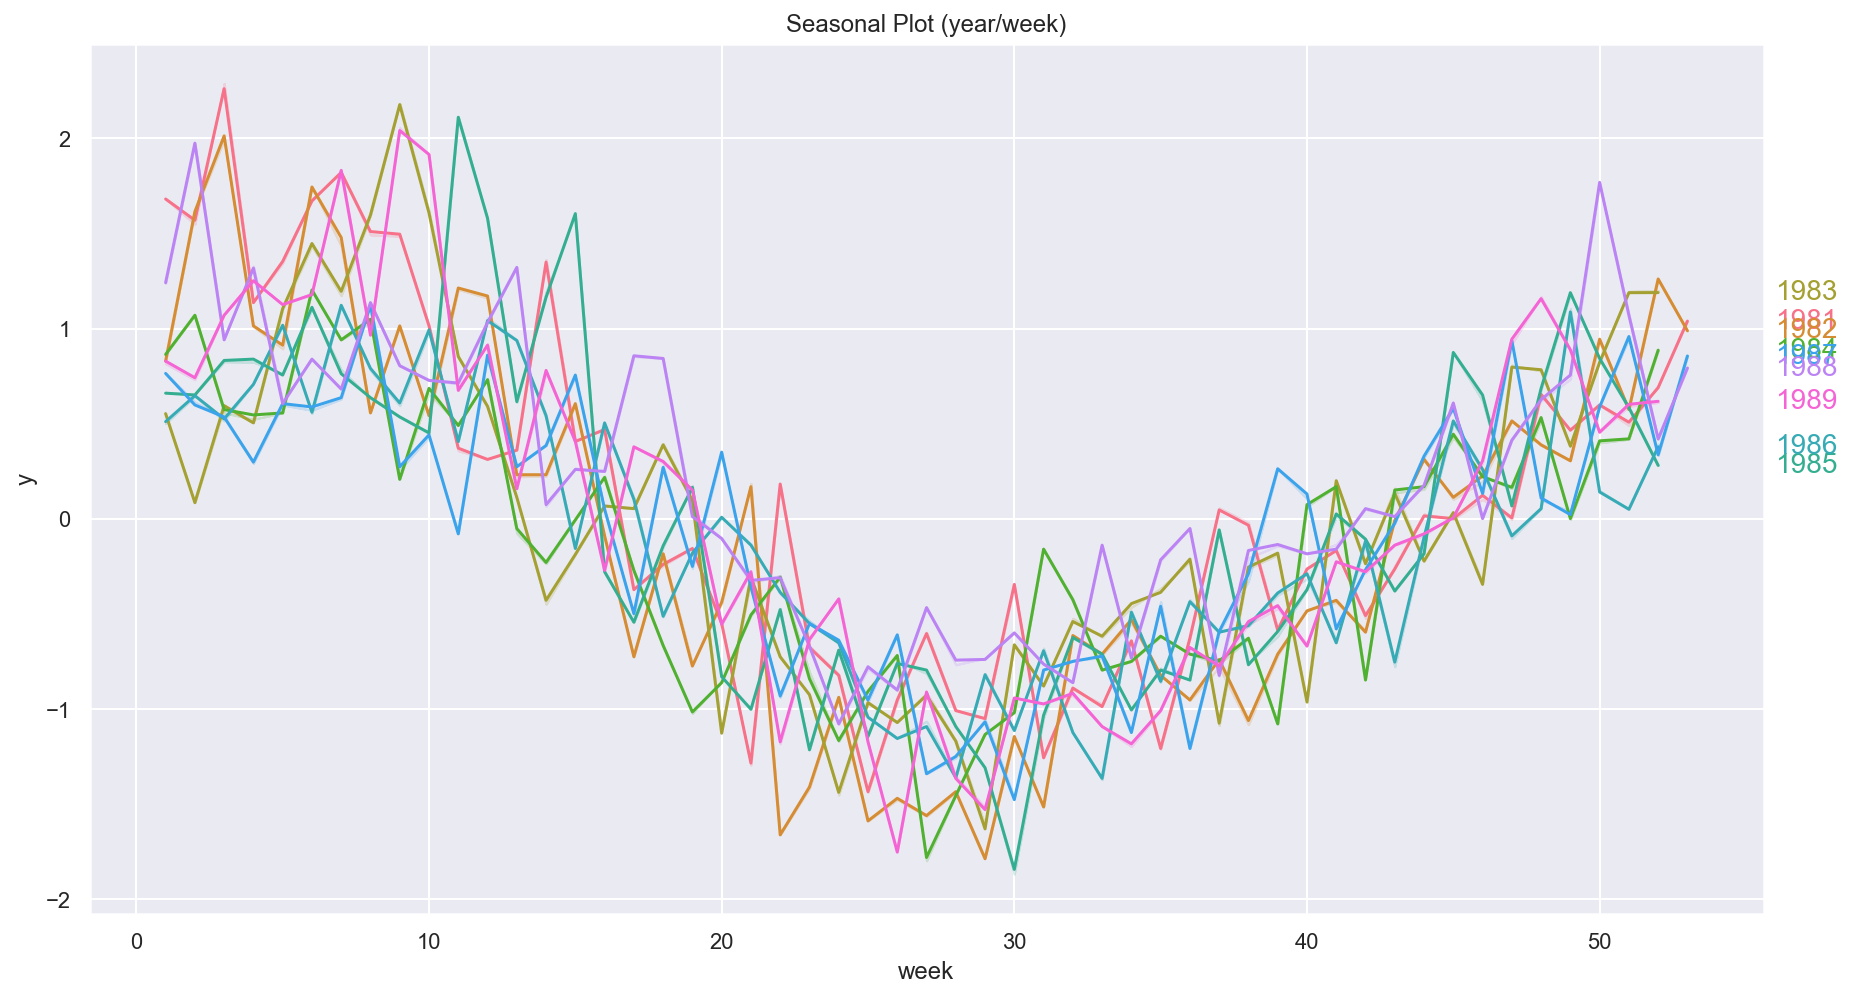

In [86]:
seasonal_plot(X, y='y', period='year', freq='week');

En el periodgrama se ve un pico máximo en la frecuencia Anual, consistente con los datos, la segunda componente es semianual (2 mitades de año).

C:\Users\flavi\AppData\Local\Temp\ipykernel_12388\3699215712.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  plot_periodogram(X.y);


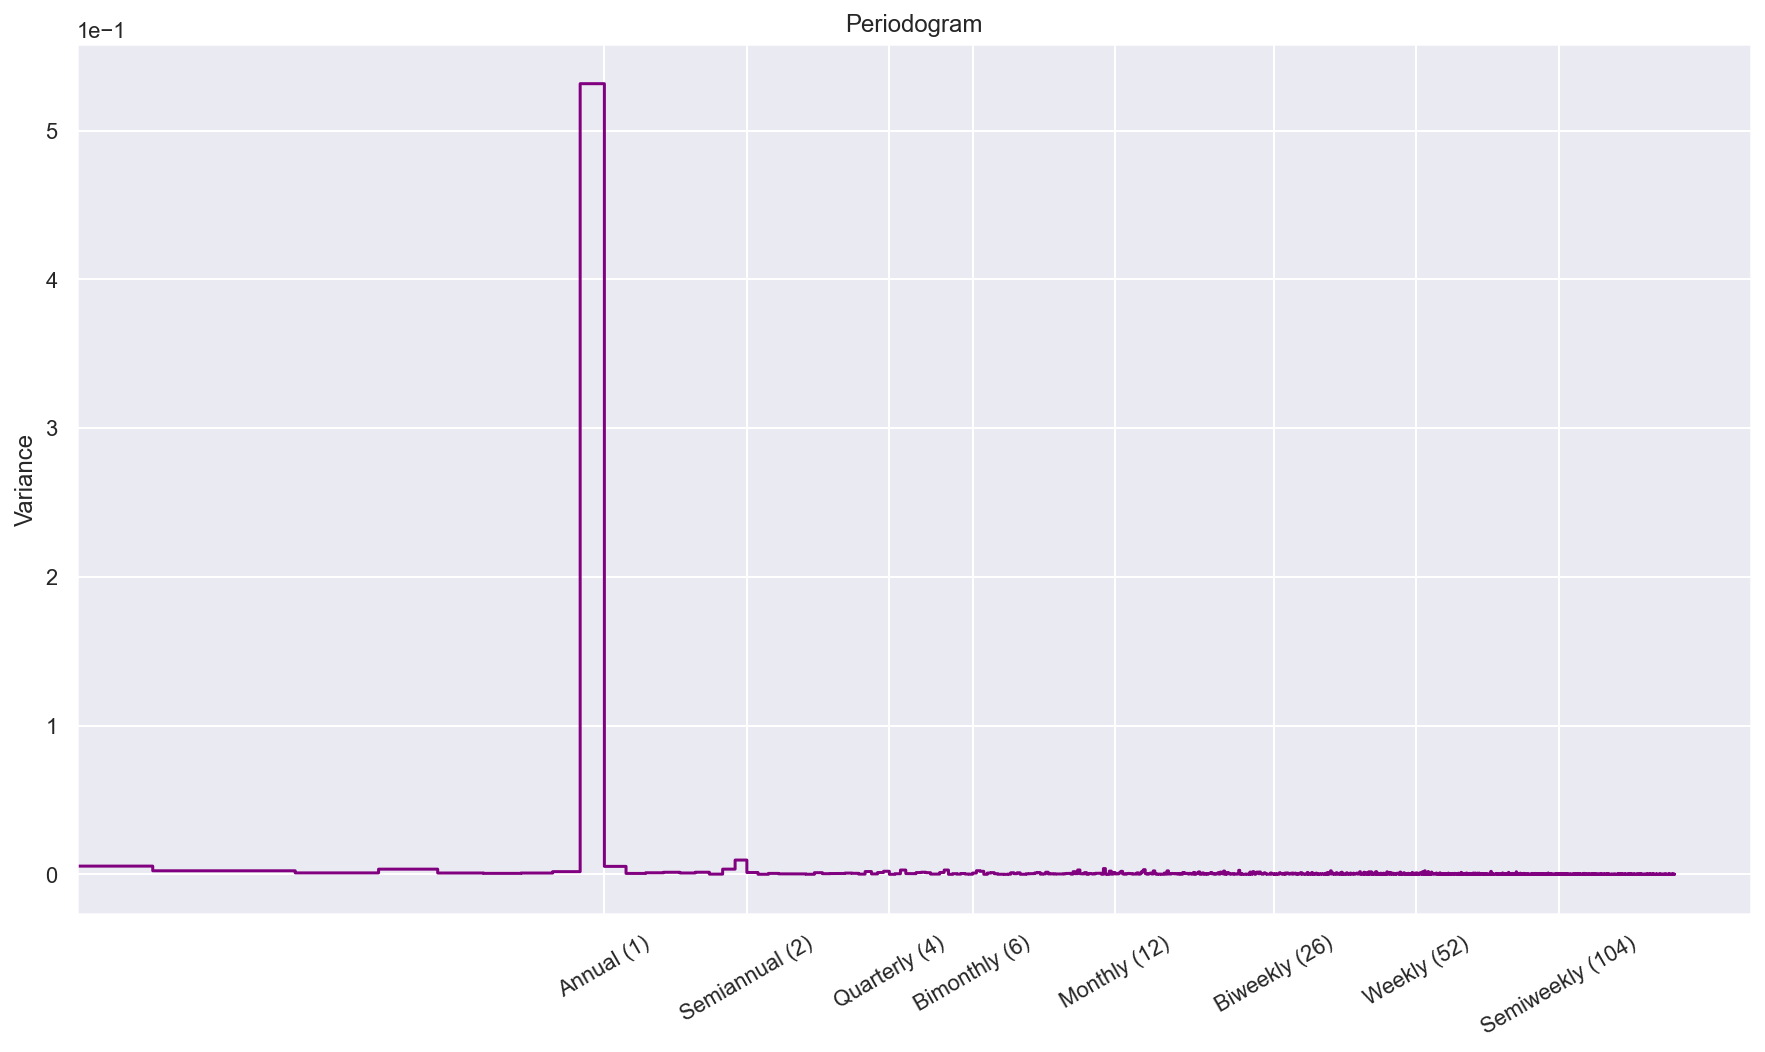

In [87]:
plot_periodogram(X.y);